In [1]:
import random
import torch
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt

from scipy.stats import norm, skewnorm

In [2]:
seed = 633

print("[ Using Seed : ", seed, " ]")

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
numpy.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

[ Using Seed :  633  ]


In [3]:
from koopman_probabilistic import *

In [4]:
zone_name = "ISONE CA"

In [20]:
import json

with open("GEFCom2017//GEFCom2017-Qual//GEFCom2017Qual2005-2015.json") as f:
    all_data = json.loads(f.read())
    
# x = np.transpose(np.array([all_data["ISONE CA"]["DEMAND"], all_data["ISONE CA"]["DewPnt"], all_data["ISONE CA"]["DryBulb"]], dtype=np.float64))
# all_zones = []
# all_temps = []
# # ['ISONE CA', 'ME', 'RI', 'VT', 'CT', 'NH', 'SEMASS', 'WCMASS', 'NEMASSBOST']
# for zone in all_data.keys():
#     all_zones.append(all_data[zone]["DEMAND"])
#     all_temps.append(all_data[zone]["DryBulb"])
# x = np.transpose(np.array(all_zones, dtype=np.float64))
x = np.transpose(np.array([all_data[zone_name]["RT_Demand"]], dtype=np.float64))

In [21]:
print(all_data[zone_name].keys())
print(all_data[zone_name]["Date"][0:24])

dict_keys(['Date', 'Hr_End', 'DA_Demand', 'RT_Demand', 'DA_LMP', 'DA_EC', 'DA_CC', 'DA_MLC', 'RT_LMP', 'RT_EC', 'RT_CC', 'RT_MLC', 'Dry_Bulb', 'Dew_Point', 'System_Load', 'Reg_Service_Price', 'Reg_Capacity_Price'])
['2016-01-01 00:00:00', '2016-01-01 00:00:00', '2016-01-01 00:00:00', '2016-01-01 00:00:00', '2016-01-01 00:00:00', '2016-01-01 00:00:00', '2016-01-01 00:00:00', '2016-01-01 00:00:00', '2016-01-01 00:00:00', '2016-01-01 00:00:00', '2016-01-01 00:00:00', '2016-01-01 00:00:00', '2016-01-01 00:00:00', '2016-01-01 00:00:00', '2016-01-01 00:00:00', '2016-01-01 00:00:00', '2016-01-01 00:00:00', '2016-01-01 00:00:00', '2016-01-01 00:00:00', '2016-01-01 00:00:00', '2016-01-01 00:00:00', '2016-01-01 00:00:00', '2016-01-01 00:00:00', '2016-01-01 00:00:00']


In [22]:
x.min()

8713.691

In [18]:
x_original = x
mean = np.mean(x, axis=0)
rnge = np.max(x, axis=0) - np.min(x, axis=0)
x = (x - np.matlib.repmat(mean, x.shape[0], 1)) / np.matlib.repmat(rnge, x.shape[0], 1)
print("x", x.shape)

x (8784, 1)


In [6]:
data_name = "oneyear" + zone_name

train_through = 365 * 24
train_start = 9 * 365 * 24 + 2 * 24  # 2 leap years in from 2005 to 2014
delay = 0  # 52 * 24  # 1.5 to 2 month gap, then 1 month forecast
x = x[train_start:]
predict_through = train_through + 24 * 31 + delay  
x = x[:predict_through]
xt = x[:train_through]

num_freqs = [4, 4, 4]
# num_freqs = [4, 4]
num_fourier = 4
mu_file = "forecasts//" + data_name + f"trained{train_start}-{train_through}_{num_freqs}mu.npy"
sigma_file = "forecasts//" + data_name + f"trained{train_start}-{train_through}_{num_freqs}sigma.npy"
alpha_file = "forecasts//" + data_name + f"trained{train_start}-{train_through}_{num_freqs}alpha.npy"
print("x", x.shape)
print("xt", xt.shape)

x (9504, 1)
xt (8760, 1)


In [57]:
model = AlternatingSkewNLL(x_dim=xt.shape[1], num_freqs=num_freqs, n=512)
k = KoopmanProb(model, device='cpu', sample_num=24, num_fourier_modes=num_fourier, batch_size=32)

In [58]:
k.find_fourier_omegas(xt, hard_code=[24, 168, 24 * 365.25 / 12, 24 * 365.25])

tensor([0.2618, 0.0374, 0.0086, 0.0007])

In [91]:
k.fit(xt, iterations=800, interval=10, verbose=True, cutoff=0, weight_decay=1e-10000, lr_theta=3e-5, lr_omega=1e-10, num_slices=None);

Iteration  0
tensor([  24.0000,  168.0000,  730.4999, 8817.8779,   24.0000,  168.0000,
         730.4999, 8805.1211,   24.0000,  168.0000,  730.4999, 8763.0615])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8817.8779,   24.0000,  168.0000,
         730.4999, 8805.1211,   24.0000,  168.0000,  730.4999, 8763.0615],
       grad_fn=<MulBackward0>)
Loss:  -1.366780658559061
Iteration  1
tensor([  24.0000,  168.0000,  730.4999, 8817.8779,   24.0000,  168.0000,
         730.4999, 8805.1211,   24.0000,  168.0000,  730.4999, 8763.0615])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8817.8779,   24.0000,  168.0000,
         730.4999, 8805.1211,   24.0000,  168.0000,  730.4999, 8763.0615],
       grad_fn=<MulBackward0>)
Loss:  -1.4119824943863521
Iteration  2
tensor([  24.0000,  168.0000,  730.4999, 8817.8779,   24.0000,  168.0000,
         730.4999, 8805.1211,   24.0000,  168.0000,  730.4999, 8763.0615])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 881

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8818.1719,   24.0000,  168.0000,
         730.4999, 8805.2900,   24.0000,  168.0000,  730.4999, 8763.0371],
       grad_fn=<MulBackward0>)
Loss:  -1.5381915797574774
Iteration  22
tensor([  24.0000,  168.0000,  730.4999, 8818.1719,   24.0000,  168.0000,
         730.4999, 8805.2900,   24.0000,  168.0000,  730.4999, 8763.0371])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8818.2197,   24.0000,  168.0000,
         730.4999, 8805.3164,   24.0000,  168.0000,  730.4999, 8763.0322],
       grad_fn=<MulBackward0>)
Loss:  -1.539036899635131
Iteration  23
tensor([  24.0000,  168.0000,  730.4999, 8818.2197,   24.0000,  168.0000,
         730.4999, 8805.3164,   24.0000,  168.0000,  730.4999, 8763.0322])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8818.2695,   24.0000,  168.0000,
         730.4999, 8805.3428,   24.0000,  168.0000,  730.4999, 8763.0254],
       grad_fn=<MulBackward0>)
Loss:  -1.53977287774894

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8819.2480,   24.0000,  168.0000,
         730.4999, 8805.8408,   24.0000,  168.0000,  730.4999, 8762.8916],
       grad_fn=<MulBackward0>)
Loss:  -1.5451172633895036
Iteration  44
tensor([  24.0000,  168.0000,  730.4999, 8819.2480,   24.0000,  168.0000,
         730.4999, 8805.8408,   24.0000,  168.0000,  730.4999, 8762.8916])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8819.2979,   24.0000,  168.0000,
         730.4999, 8805.8662,   24.0000,  168.0000,  730.4999, 8762.8857],
       grad_fn=<MulBackward0>)
Loss:  -1.54521698255163
Iteration  45
tensor([  24.0000,  168.0000,  730.4999, 8819.2979,   24.0000,  168.0000,
         730.4999, 8805.8662,   24.0000,  168.0000,  730.4999, 8762.8857])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8819.3467,   24.0000,  168.0000,
         730.4999, 8805.8916,   24.0000,  168.0000,  730.4999, 8762.8779],
       grad_fn=<MulBackward0>)
Loss:  -1.545312594155071

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8820.3145,   24.0000,  168.0000,
         730.4999, 8806.3926,   24.0000,  168.0000,  730.4999, 8762.7256],
       grad_fn=<MulBackward0>)
Loss:  -1.5468152569390239
Iteration  66
tensor([  24.0000,  168.0000,  730.4999, 8820.3145,   24.0000,  168.0000,
         730.4999, 8806.3926,   24.0000,  168.0000,  730.4999, 8762.7256])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8820.3623,   24.0000,  168.0000,
         730.4999, 8806.4180,   24.0000,  168.0000,  730.4999, 8762.7178],
       grad_fn=<MulBackward0>)
Loss:  -1.5468799653937952
Iteration  67
tensor([  24.0000,  168.0000,  730.4999, 8820.3623,   24.0000,  168.0000,
         730.4999, 8806.4180,   24.0000,  168.0000,  730.4999, 8762.7178])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8820.4102,   24.0000,  168.0000,
         730.4999, 8806.4424,   24.0000,  168.0000,  730.4999, 8762.7109],
       grad_fn=<MulBackward0>)
Loss:  -1.5469443842212

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8821.3818,   24.0000,  168.0000,
         730.4999, 8806.9258,   24.0000,  168.0000,  730.4999, 8762.5537],
       grad_fn=<MulBackward0>)
Loss:  -1.548121391894299
Iteration  88
tensor([  24.0000,  168.0000,  730.4999, 8821.3818,   24.0000,  168.0000,
         730.4999, 8806.9258,   24.0000,  168.0000,  730.4999, 8762.5537])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8821.4307,   24.0000,  168.0000,
         730.4999, 8806.9502,   24.0000,  168.0000,  730.4999, 8762.5469],
       grad_fn=<MulBackward0>)
Loss:  -1.5481748533325854
Iteration  89
tensor([  24.0000,  168.0000,  730.4999, 8821.4307,   24.0000,  168.0000,
         730.4999, 8806.9502,   24.0000,  168.0000,  730.4999, 8762.5469])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8821.4785,   24.0000,  168.0000,
         730.4999, 8806.9736,   24.0000,  168.0000,  730.4999, 8762.5410],
       grad_fn=<MulBackward0>)
Loss:  -1.54822791441560

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8822.4619,   24.0000,  168.0000,
         730.4999, 8807.4629,   24.0000,  168.0000,  730.4999, 8762.4170],
       grad_fn=<MulBackward0>)
Loss:  -1.5491975746119013
Iteration  110
tensor([  24.0000,  168.0000,  730.4999, 8822.4619,   24.0000,  168.0000,
         730.4999, 8807.4629,   24.0000,  168.0000,  730.4999, 8762.4170])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8822.5117,   24.0000,  168.0000,
         730.4999, 8807.4873,   24.0000,  168.0000,  730.4999, 8762.4111],
       grad_fn=<MulBackward0>)
Loss:  -1.5492419146192642
Iteration  111
tensor([  24.0000,  168.0000,  730.4999, 8822.5117,   24.0000,  168.0000,
         730.4999, 8807.4873,   24.0000,  168.0000,  730.4999, 8762.4111])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8822.5615,   24.0000,  168.0000,
         730.4999, 8807.5117,   24.0000,  168.0000,  730.4999, 8762.4062],
       grad_fn=<MulBackward0>)
Loss:  -1.54928565671

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8823.5684,   24.0000,  168.0000,
         730.4999, 8807.9883,   24.0000,  168.0000,  730.4999, 8762.2998],
       grad_fn=<MulBackward0>)
Loss:  -1.5500902427665695
Iteration  132
tensor([  24.0000,  168.0000,  730.4999, 8823.5684,   24.0000,  168.0000,
         730.4999, 8807.9883,   24.0000,  168.0000,  730.4999, 8762.2998])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8823.6182,   24.0000,  168.0000,
         730.4999, 8808.0117,   24.0000,  168.0000,  730.4999, 8762.2959],
       grad_fn=<MulBackward0>)
Loss:  -1.550126966095134
Iteration  133
tensor([  24.0000,  168.0000,  730.4999, 8823.6182,   24.0000,  168.0000,
         730.4999, 8808.0117,   24.0000,  168.0000,  730.4999, 8762.2959])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8823.6680,   24.0000,  168.0000,
         730.4999, 8808.0352,   24.0000,  168.0000,  730.4999, 8762.2900],
       grad_fn=<MulBackward0>)
Loss:  -1.550163575793

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8824.6553,   24.0000,  168.0000,
         730.4999, 8808.5146,   24.0000,  168.0000,  730.4999, 8762.1875],
       grad_fn=<MulBackward0>)
Loss:  -1.5508377369932111
Iteration  154
tensor([  24.0000,  168.0000,  730.4999, 8824.6553,   24.0000,  168.0000,
         730.4999, 8808.5146,   24.0000,  168.0000,  730.4999, 8762.1875])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8824.7051,   24.0000,  168.0000,
         730.4999, 8808.5391,   24.0000,  168.0000,  730.4999, 8762.1816],
       grad_fn=<MulBackward0>)
Loss:  -1.5508688512004936
Iteration  155
tensor([  24.0000,  168.0000,  730.4999, 8824.7051,   24.0000,  168.0000,
         730.4999, 8808.5391,   24.0000,  168.0000,  730.4999, 8762.1816])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8824.7549,   24.0000,  168.0000,
         730.4999, 8808.5635,   24.0000,  168.0000,  730.4999, 8762.1758],
       grad_fn=<MulBackward0>)
Loss:  -1.55089993936

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8825.7432,   24.0000,  168.0000,
         730.4999, 8809.0723,   24.0000,  168.0000,  730.4999, 8762.0713],
       grad_fn=<MulBackward0>)
Loss:  -1.551476857394616
Iteration  176
tensor([  24.0000,  168.0000,  730.4999, 8825.7432,   24.0000,  168.0000,
         730.4999, 8809.0723,   24.0000,  168.0000,  730.4999, 8762.0713])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8825.7920,   24.0000,  168.0000,
         730.4999, 8809.0977,   24.0000,  168.0000,  730.4999, 8762.0654],
       grad_fn=<MulBackward0>)
Loss:  -1.5515035977214933
Iteration  177
tensor([  24.0000,  168.0000,  730.4999, 8825.7920,   24.0000,  168.0000,
         730.4999, 8809.0977,   24.0000,  168.0000,  730.4999, 8762.0654])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8825.8418,   24.0000,  168.0000,
         730.4999, 8809.1230,   24.0000,  168.0000,  730.4999, 8762.0605],
       grad_fn=<MulBackward0>)
Loss:  -1.551530490530

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8826.7979,   24.0000,  168.0000,
         730.4999, 8809.6416,   24.0000,  168.0000,  730.4999, 8761.9854],
       grad_fn=<MulBackward0>)
Loss:  -1.5520295197684753
Iteration  198
tensor([  24.0000,  168.0000,  730.4999, 8826.7979,   24.0000,  168.0000,
         730.4999, 8809.6416,   24.0000,  168.0000,  730.4999, 8761.9854])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8826.8447,   24.0000,  168.0000,
         730.4999, 8809.6670,   24.0000,  168.0000,  730.4999, 8761.9814],
       grad_fn=<MulBackward0>)
Loss:  -1.5520530671135957
Iteration  199
tensor([  24.0000,  168.0000,  730.4999, 8826.8447,   24.0000,  168.0000,
         730.4999, 8809.6670,   24.0000,  168.0000,  730.4999, 8761.9814])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8826.8916,   24.0000,  168.0000,
         730.4999, 8809.6934,   24.0000,  168.0000,  730.4999, 8761.9785],
       grad_fn=<MulBackward0>)
Loss:  -1.55207625452

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8827.8350,   24.0000,  168.0000,
         730.4999, 8810.2090,   24.0000,  168.0000,  730.4999, 8761.9072],
       grad_fn=<MulBackward0>)
Loss:  -1.552518602467999
Iteration  220
tensor([  24.0000,  168.0000,  730.4999, 8827.8350,   24.0000,  168.0000,
         730.4999, 8810.2090,   24.0000,  168.0000,  730.4999, 8761.9072])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8827.8809,   24.0000,  168.0000,
         730.4999, 8810.2344,   24.0000,  168.0000,  730.4999, 8761.9033],
       grad_fn=<MulBackward0>)
Loss:  -1.5525395947193927
Iteration  221
tensor([  24.0000,  168.0000,  730.4999, 8827.8809,   24.0000,  168.0000,
         730.4999, 8810.2344,   24.0000,  168.0000,  730.4999, 8761.9033])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8827.9277,   24.0000,  168.0000,
         730.4999, 8810.2607,   24.0000,  168.0000,  730.4999, 8761.8994],
       grad_fn=<MulBackward0>)
Loss:  -1.552560628312

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8828.8672,   24.0000,  168.0000,
         730.4999, 8810.7988,   24.0000,  168.0000,  730.4999, 8761.8350],
       grad_fn=<MulBackward0>)
Loss:  -1.5529633437588837
Iteration  242
tensor([  24.0000,  168.0000,  730.4999, 8828.8672,   24.0000,  168.0000,
         730.4999, 8810.7988,   24.0000,  168.0000,  730.4999, 8761.8350])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8828.9160,   24.0000,  168.0000,
         730.4999, 8810.8242,   24.0000,  168.0000,  730.4999, 8761.8320],
       grad_fn=<MulBackward0>)
Loss:  -1.5529827733646047
Iteration  243
tensor([  24.0000,  168.0000,  730.4999, 8828.9160,   24.0000,  168.0000,
         730.4999, 8810.8242,   24.0000,  168.0000,  730.4999, 8761.8320])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8828.9629,   24.0000,  168.0000,
         730.4999, 8810.8516,   24.0000,  168.0000,  730.4999, 8761.8291],
       grad_fn=<MulBackward0>)
Loss:  -1.55300224438

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8829.9170,   24.0000,  168.0000,
         730.4999, 8811.3945,   24.0000,  168.0000,  730.4999, 8761.7725],
       grad_fn=<MulBackward0>)
Loss:  -1.553379118384183
Iteration  264
tensor([  24.0000,  168.0000,  730.4999, 8829.9170,   24.0000,  168.0000,
         730.4999, 8811.3945,   24.0000,  168.0000,  730.4999, 8761.7725])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8829.9639,   24.0000,  168.0000,
         730.4999, 8811.4229,   24.0000,  168.0000,  730.4999, 8761.7705],
       grad_fn=<MulBackward0>)
Loss:  -1.5533971915512563
Iteration  265
tensor([  24.0000,  168.0000,  730.4999, 8829.9639,   24.0000,  168.0000,
         730.4999, 8811.4229,   24.0000,  168.0000,  730.4999, 8761.7705])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8830.0117,   24.0000,  168.0000,
         730.4999, 8811.4521,   24.0000,  168.0000,  730.4999, 8761.7676],
       grad_fn=<MulBackward0>)
Loss:  -1.553415637796

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8830.9961,   24.0000,  168.0000,
         730.4999, 8812.0371,   24.0000,  168.0000,  730.4999, 8761.7217],
       grad_fn=<MulBackward0>)
Loss:  -1.5537784329051396
Iteration  286
tensor([  24.0000,  168.0000,  730.4999, 8830.9961,   24.0000,  168.0000,
         730.4999, 8812.0371,   24.0000,  168.0000,  730.4999, 8761.7217])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8831.0449,   24.0000,  168.0000,
         730.4999, 8812.0674,   24.0000,  168.0000,  730.4999, 8761.7197],
       grad_fn=<MulBackward0>)
Loss:  -1.5537963230433878
Iteration  287
tensor([  24.0000,  168.0000,  730.4999, 8831.0449,   24.0000,  168.0000,
         730.4999, 8812.0674,   24.0000,  168.0000,  730.4999, 8761.7197])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8831.0938,   24.0000,  168.0000,
         730.4999, 8812.0967,   24.0000,  168.0000,  730.4999, 8761.7178],
       grad_fn=<MulBackward0>)
Loss:  -1.55381410050

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8832.0938,   24.0000,  168.0000,
         730.4999, 8812.6865,   24.0000,  168.0000,  730.4999, 8761.6748],
       grad_fn=<MulBackward0>)
Loss:  -1.55416699930183
Iteration  308
tensor([  24.0000,  168.0000,  730.4999, 8832.0938,   24.0000,  168.0000,
         730.4999, 8812.6865,   24.0000,  168.0000,  730.4999, 8761.6748])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8832.1436,   24.0000,  168.0000,
         730.4999, 8812.7158,   24.0000,  168.0000,  730.4999, 8761.6729],
       grad_fn=<MulBackward0>)
Loss:  -1.5541846080039243
Iteration  309
tensor([  24.0000,  168.0000,  730.4999, 8832.1436,   24.0000,  168.0000,
         730.4999, 8812.7158,   24.0000,  168.0000,  730.4999, 8761.6729])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8832.1943,   24.0000,  168.0000,
         730.4999, 8812.7451,   24.0000,  168.0000,  730.4999, 8761.6709],
       grad_fn=<MulBackward0>)
Loss:  -1.5542020177272

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8833.2061,   24.0000,  168.0000,
         730.4999, 8813.3496,   24.0000,  168.0000,  730.4999, 8761.6279],
       grad_fn=<MulBackward0>)
Loss:  -1.554551528044949
Iteration  330
tensor([  24.0000,  168.0000,  730.4999, 8833.2061,   24.0000,  168.0000,
         730.4999, 8813.3496,   24.0000,  168.0000,  730.4999, 8761.6279])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8833.2568,   24.0000,  168.0000,
         730.4999, 8813.3799,   24.0000,  168.0000,  730.4999, 8761.6250],
       grad_fn=<MulBackward0>)
Loss:  -1.554568979577536
Iteration  331
tensor([  24.0000,  168.0000,  730.4999, 8833.2568,   24.0000,  168.0000,
         730.4999, 8813.3799,   24.0000,  168.0000,  730.4999, 8761.6250])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8833.3086,   24.0000,  168.0000,
         730.4999, 8813.4102,   24.0000,  168.0000,  730.4999, 8761.6240],
       grad_fn=<MulBackward0>)
Loss:  -1.5545864222312

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8834.3340,   24.0000,  168.0000,
         730.4999, 8814.0098,   24.0000,  168.0000,  730.4999, 8761.5811],
       grad_fn=<MulBackward0>)
Loss:  -1.5549344969973158
Iteration  352
tensor([  24.0000,  168.0000,  730.4999, 8834.3340,   24.0000,  168.0000,
         730.4999, 8814.0098,   24.0000,  168.0000,  730.4999, 8761.5811])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8834.3857,   24.0000,  168.0000,
         730.4999, 8814.0400,   24.0000,  168.0000,  730.4999, 8761.5781],
       grad_fn=<MulBackward0>)
Loss:  -1.5549519722184244
Iteration  353
tensor([  24.0000,  168.0000,  730.4999, 8834.3857,   24.0000,  168.0000,
         730.4999, 8814.0400,   24.0000,  168.0000,  730.4999, 8761.5781])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8834.4375,   24.0000,  168.0000,
         730.4999, 8814.0703,   24.0000,  168.0000,  730.4999, 8761.5762],
       grad_fn=<MulBackward0>)
Loss:  -1.55496967871

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8835.4453,   24.0000,  168.0000,
         730.4999, 8814.6748,   24.0000,  168.0000,  730.4999, 8761.5361],
       grad_fn=<MulBackward0>)
Loss:  -1.5553184367959354
Iteration  374
tensor([  24.0000,  168.0000,  730.4999, 8835.4453,   24.0000,  168.0000,
         730.4999, 8814.6748,   24.0000,  168.0000,  730.4999, 8761.5361])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8835.4961,   24.0000,  168.0000,
         730.4999, 8814.7051,   24.0000,  168.0000,  730.4999, 8761.5352],
       grad_fn=<MulBackward0>)
Loss:  -1.5553356578613726
Iteration  375
tensor([  24.0000,  168.0000,  730.4999, 8835.4961,   24.0000,  168.0000,
         730.4999, 8814.7051,   24.0000,  168.0000,  730.4999, 8761.5352])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8835.5459,   24.0000,  168.0000,
         730.4999, 8814.7354,   24.0000,  168.0000,  730.4999, 8761.5342],
       grad_fn=<MulBackward0>)
Loss:  -1.55535330094

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8836.5488,   24.0000,  168.0000,
         730.4999, 8815.3555,   24.0000,  168.0000,  730.4999, 8761.4971],
       grad_fn=<MulBackward0>)
Loss:  -1.5557058672943338
Iteration  396
tensor([  24.0000,  168.0000,  730.4999, 8836.5488,   24.0000,  168.0000,
         730.4999, 8815.3555,   24.0000,  168.0000,  730.4999, 8761.4971])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8836.5986,   24.0000,  168.0000,
         730.4999, 8815.3867,   24.0000,  168.0000,  730.4999, 8761.4951],
       grad_fn=<MulBackward0>)
Loss:  -1.5557237086237272
Iteration  397
tensor([  24.0000,  168.0000,  730.4999, 8836.5986,   24.0000,  168.0000,
         730.4999, 8815.3867,   24.0000,  168.0000,  730.4999, 8761.4951])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8836.6494,   24.0000,  168.0000,
         730.4999, 8815.4180,   24.0000,  168.0000,  730.4999, 8761.4922],
       grad_fn=<MulBackward0>)
Loss:  -1.55574148698

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8837.6406,   24.0000,  168.0000,
         730.4999, 8816.0586,   24.0000,  168.0000,  730.4999, 8761.4346],
       grad_fn=<MulBackward0>)
Loss:  -1.556099481795992
Iteration  418
tensor([  24.0000,  168.0000,  730.4999, 8837.6406,   24.0000,  168.0000,
         730.4999, 8816.0586,   24.0000,  168.0000,  730.4999, 8761.4346])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8837.6904,   24.0000,  168.0000,
         730.4999, 8816.0908,   24.0000,  168.0000,  730.4999, 8761.4316],
       grad_fn=<MulBackward0>)
Loss:  -1.556117562940053
Iteration  419
tensor([  24.0000,  168.0000,  730.4999, 8837.6904,   24.0000,  168.0000,
         730.4999, 8816.0908,   24.0000,  168.0000,  730.4999, 8761.4316])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8837.7393,   24.0000,  168.0000,
         730.4999, 8816.1230,   24.0000,  168.0000,  730.4999, 8761.4287],
       grad_fn=<MulBackward0>)
Loss:  -1.5561352795539

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8838.7334,   24.0000,  168.0000,
         730.4999, 8816.7637,   24.0000,  168.0000,  730.4999, 8761.3740],
       grad_fn=<MulBackward0>)
Loss:  -1.5565002078285866
Iteration  440
tensor([  24.0000,  168.0000,  730.4999, 8838.7334,   24.0000,  168.0000,
         730.4999, 8816.7637,   24.0000,  168.0000,  730.4999, 8761.3740])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8838.7842,   24.0000,  168.0000,
         730.4999, 8816.7949,   24.0000,  168.0000,  730.4999, 8761.3711],
       grad_fn=<MulBackward0>)
Loss:  -1.5565183775747218
Iteration  441
tensor([  24.0000,  168.0000,  730.4999, 8838.7842,   24.0000,  168.0000,
         730.4999, 8816.7949,   24.0000,  168.0000,  730.4999, 8761.3711])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8838.8340,   24.0000,  168.0000,
         730.4999, 8816.8271,   24.0000,  168.0000,  730.4999, 8761.3691],
       grad_fn=<MulBackward0>)
Loss:  -1.55653673035

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8839.8457,   24.0000,  168.0000,
         730.4999, 8817.4609,   24.0000,  168.0000,  730.4999, 8761.3115],
       grad_fn=<MulBackward0>)
Loss:  -1.5569080812790728
Iteration  462
tensor([  24.0000,  168.0000,  730.4999, 8839.8457,   24.0000,  168.0000,
         730.4999, 8817.4609,   24.0000,  168.0000,  730.4999, 8761.3115])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8839.8965,   24.0000,  168.0000,
         730.4999, 8817.4922,   24.0000,  168.0000,  730.4999, 8761.3096],
       grad_fn=<MulBackward0>)
Loss:  -1.556926745337934
Iteration  463
tensor([  24.0000,  168.0000,  730.4999, 8839.8965,   24.0000,  168.0000,
         730.4999, 8817.4922,   24.0000,  168.0000,  730.4999, 8761.3096])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8839.9473,   24.0000,  168.0000,
         730.4999, 8817.5244,   24.0000,  168.0000,  730.4999, 8761.3066],
       grad_fn=<MulBackward0>)
Loss:  -1.556945546079

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8840.9551,   24.0000,  168.0000,
         730.4999, 8818.1582,   24.0000,  168.0000,  730.4999, 8761.2490],
       grad_fn=<MulBackward0>)
Loss:  -1.557323092147049
Iteration  484
tensor([  24.0000,  168.0000,  730.4999, 8840.9551,   24.0000,  168.0000,
         730.4999, 8818.1582,   24.0000,  168.0000,  730.4999, 8761.2490])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8841.0049,   24.0000,  168.0000,
         730.4999, 8818.1895,   24.0000,  168.0000,  730.4999, 8761.2461],
       grad_fn=<MulBackward0>)
Loss:  -1.557342073061747
Iteration  485
tensor([  24.0000,  168.0000,  730.4999, 8841.0049,   24.0000,  168.0000,
         730.4999, 8818.1895,   24.0000,  168.0000,  730.4999, 8761.2461])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8841.0547,   24.0000,  168.0000,
         730.4999, 8818.2217,   24.0000,  168.0000,  730.4999, 8761.2432],
       grad_fn=<MulBackward0>)
Loss:  -1.5573609168856

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8842.0645,   24.0000,  168.0000,
         730.4999, 8818.8447,   24.0000,  168.0000,  730.4999, 8761.1865],
       grad_fn=<MulBackward0>)
Loss:  -1.5577451261834019
Iteration  506
tensor([  24.0000,  168.0000,  730.4999, 8842.0645,   24.0000,  168.0000,
         730.4999, 8818.8447,   24.0000,  168.0000,  730.4999, 8761.1865])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8842.1172,   24.0000,  168.0000,
         730.4999, 8818.8750,   24.0000,  168.0000,  730.4999, 8761.1846],
       grad_fn=<MulBackward0>)
Loss:  -1.5577642853574865
Iteration  507
tensor([  24.0000,  168.0000,  730.4999, 8842.1172,   24.0000,  168.0000,
         730.4999, 8818.8750,   24.0000,  168.0000,  730.4999, 8761.1846])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8842.1689,   24.0000,  168.0000,
         730.4999, 8818.9053,   24.0000,  168.0000,  730.4999, 8761.1816],
       grad_fn=<MulBackward0>)
Loss:  -1.55778364846

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8843.2119,   24.0000,  168.0000,
         730.4999, 8819.5098,   24.0000,  168.0000,  730.4999, 8761.1240],
       grad_fn=<MulBackward0>)
Loss:  -1.558175931980281
Iteration  528
tensor([  24.0000,  168.0000,  730.4999, 8843.2119,   24.0000,  168.0000,
         730.4999, 8819.5098,   24.0000,  168.0000,  730.4999, 8761.1240])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8843.2646,   24.0000,  168.0000,
         730.4999, 8819.5410,   24.0000,  168.0000,  730.4999, 8761.1201],
       grad_fn=<MulBackward0>)
Loss:  -1.5581955679339603
Iteration  529
tensor([  24.0000,  168.0000,  730.4999, 8843.2646,   24.0000,  168.0000,
         730.4999, 8819.5410,   24.0000,  168.0000,  730.4999, 8761.1201])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8843.3154,   24.0000,  168.0000,
         730.4999, 8819.5703,   24.0000,  168.0000,  730.4999, 8761.1172],
       grad_fn=<MulBackward0>)
Loss:  -1.558215352387

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8844.3574,   24.0000,  168.0000,
         730.4999, 8820.1797,   24.0000,  168.0000,  730.4999, 8761.0459],
       grad_fn=<MulBackward0>)
Loss:  -1.5586138919798491
Iteration  550
tensor([  24.0000,  168.0000,  730.4999, 8844.3574,   24.0000,  168.0000,
         730.4999, 8820.1797,   24.0000,  168.0000,  730.4999, 8761.0459])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8844.4102,   24.0000,  168.0000,
         730.4999, 8820.2100,   24.0000,  168.0000,  730.4999, 8761.0420],
       grad_fn=<MulBackward0>)
Loss:  -1.558634283888177
Iteration  551
tensor([  24.0000,  168.0000,  730.4999, 8844.4102,   24.0000,  168.0000,
         730.4999, 8820.2100,   24.0000,  168.0000,  730.4999, 8761.0420])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8844.4629,   24.0000,  168.0000,
         730.4999, 8820.2422,   24.0000,  168.0000,  730.4999, 8761.0381],
       grad_fn=<MulBackward0>)
Loss:  -1.558654364649

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8845.5391,   24.0000,  168.0000,
         730.4999, 8820.8545,   24.0000,  168.0000,  730.4999, 8760.9678],
       grad_fn=<MulBackward0>)
Loss:  -1.5590634643750592
Iteration  572
tensor([  24.0000,  168.0000,  730.4999, 8845.5391,   24.0000,  168.0000,
         730.4999, 8820.8545,   24.0000,  168.0000,  730.4999, 8760.9678])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8845.5928,   24.0000,  168.0000,
         730.4999, 8820.8848,   24.0000,  168.0000,  730.4999, 8760.9639],
       grad_fn=<MulBackward0>)
Loss:  -1.5590838164125054
Iteration  573
tensor([  24.0000,  168.0000,  730.4999, 8845.5928,   24.0000,  168.0000,
         730.4999, 8820.8848,   24.0000,  168.0000,  730.4999, 8760.9639])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8845.6475,   24.0000,  168.0000,
         730.4999, 8820.9150,   24.0000,  168.0000,  730.4999, 8760.9609],
       grad_fn=<MulBackward0>)
Loss:  -1.55910438320

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8846.7441,   24.0000,  168.0000,
         730.4999, 8821.5205,   24.0000,  168.0000,  730.4999, 8760.8896],
       grad_fn=<MulBackward0>)
Loss:  -1.5595197566532888
Iteration  594
tensor([  24.0000,  168.0000,  730.4999, 8846.7441,   24.0000,  168.0000,
         730.4999, 8821.5205,   24.0000,  168.0000,  730.4999, 8760.8896])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8846.8008,   24.0000,  168.0000,
         730.4999, 8821.5508,   24.0000,  168.0000,  730.4999, 8760.8857],
       grad_fn=<MulBackward0>)
Loss:  -1.559540650806539
Iteration  595
tensor([  24.0000,  168.0000,  730.4999, 8846.8008,   24.0000,  168.0000,
         730.4999, 8821.5508,   24.0000,  168.0000,  730.4999, 8760.8857])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8846.8564,   24.0000,  168.0000,
         730.4999, 8821.5811,   24.0000,  168.0000,  730.4999, 8760.8828],
       grad_fn=<MulBackward0>)
Loss:  -1.559561886431

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8847.9736,   24.0000,  168.0000,
         730.4999, 8822.1953,   24.0000,  168.0000,  730.4999, 8760.8115],
       grad_fn=<MulBackward0>)
Loss:  -1.5599863227129243
Iteration  616
tensor([  24.0000,  168.0000,  730.4999, 8847.9736,   24.0000,  168.0000,
         730.4999, 8822.1953,   24.0000,  168.0000,  730.4999, 8760.8115])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8848.0303,   24.0000,  168.0000,
         730.4999, 8822.2266,   24.0000,  168.0000,  730.4999, 8760.8076],
       grad_fn=<MulBackward0>)
Loss:  -1.5600079387803178
Iteration  617
tensor([  24.0000,  168.0000,  730.4999, 8848.0303,   24.0000,  168.0000,
         730.4999, 8822.2266,   24.0000,  168.0000,  730.4999, 8760.8076])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8848.0869,   24.0000,  168.0000,
         730.4999, 8822.2588,   24.0000,  168.0000,  730.4999, 8760.8047],
       grad_fn=<MulBackward0>)
Loss:  -1.56002931429

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8849.2188,   24.0000,  168.0000,
         730.4999, 8822.9053,   24.0000,  168.0000,  730.4999, 8760.7334],
       grad_fn=<MulBackward0>)
Loss:  -1.560462371774114
Iteration  638
tensor([  24.0000,  168.0000,  730.4999, 8849.2188,   24.0000,  168.0000,
         730.4999, 8822.9053,   24.0000,  168.0000,  730.4999, 8760.7334])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8849.2744,   24.0000,  168.0000,
         730.4999, 8822.9375,   24.0000,  168.0000,  730.4999, 8760.7295],
       grad_fn=<MulBackward0>)
Loss:  -1.5604841285816657
Iteration  639
tensor([  24.0000,  168.0000,  730.4999, 8849.2744,   24.0000,  168.0000,
         730.4999, 8822.9375,   24.0000,  168.0000,  730.4999, 8760.7295])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8849.3311,   24.0000,  168.0000,
         730.4999, 8822.9707,   24.0000,  168.0000,  730.4999, 8760.7266],
       grad_fn=<MulBackward0>)
Loss:  -1.560506153914

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8850.4785,   24.0000,  168.0000,
         730.4999, 8823.6299,   24.0000,  168.0000,  730.4999, 8760.6553],
       grad_fn=<MulBackward0>)
Loss:  -1.5609477949031592
Iteration  660
tensor([  24.0000,  168.0000,  730.4999, 8850.4785,   24.0000,  168.0000,
         730.4999, 8823.6299,   24.0000,  168.0000,  730.4999, 8760.6553])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8850.5352,   24.0000,  168.0000,
         730.4999, 8823.6631,   24.0000,  168.0000,  730.4999, 8760.6514],
       grad_fn=<MulBackward0>)
Loss:  -1.560969869300397
Iteration  661
tensor([  24.0000,  168.0000,  730.4999, 8850.5352,   24.0000,  168.0000,
         730.4999, 8823.6631,   24.0000,  168.0000,  730.4999, 8760.6514])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8850.5908,   24.0000,  168.0000,
         730.4999, 8823.6963,   24.0000,  168.0000,  730.4999, 8760.6484],
       grad_fn=<MulBackward0>)
Loss:  -1.560992239954

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8851.7158,   24.0000,  168.0000,
         730.4999, 8824.3496,   24.0000,  168.0000,  730.4999, 8760.5850],
       grad_fn=<MulBackward0>)
Loss:  -1.5614367275303087
Iteration  682
tensor([  24.0000,  168.0000,  730.4999, 8851.7158,   24.0000,  168.0000,
         730.4999, 8824.3496,   24.0000,  168.0000,  730.4999, 8760.5850])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8851.7725,   24.0000,  168.0000,
         730.4999, 8824.3828,   24.0000,  168.0000,  730.4999, 8760.5820],
       grad_fn=<MulBackward0>)
Loss:  -1.5614592455510048
Iteration  683
tensor([  24.0000,  168.0000,  730.4999, 8851.7725,   24.0000,  168.0000,
         730.4999, 8824.3828,   24.0000,  168.0000,  730.4999, 8760.5820])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8851.8291,   24.0000,  168.0000,
         730.4999, 8824.4160,   24.0000,  168.0000,  730.4999, 8760.5801],
       grad_fn=<MulBackward0>)
Loss:  -1.56148190586

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8852.9619,   24.0000,  168.0000,
         730.4999, 8825.0801,   24.0000,  168.0000,  730.4999, 8760.5361],
       grad_fn=<MulBackward0>)
Loss:  -1.561933842660626
Iteration  704
tensor([  24.0000,  168.0000,  730.4999, 8852.9619,   24.0000,  168.0000,
         730.4999, 8825.0801,   24.0000,  168.0000,  730.4999, 8760.5361])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8853.0195,   24.0000,  168.0000,
         730.4999, 8825.1143,   24.0000,  168.0000,  730.4999, 8760.5342],
       grad_fn=<MulBackward0>)
Loss:  -1.561956620415627
Iteration  705
tensor([  24.0000,  168.0000,  730.4999, 8853.0195,   24.0000,  168.0000,
         730.4999, 8825.1143,   24.0000,  168.0000,  730.4999, 8760.5342])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8853.0771,   24.0000,  168.0000,
         730.4999, 8825.1484,   24.0000,  168.0000,  730.4999, 8760.5322],
       grad_fn=<MulBackward0>)
Loss:  -1.5619792161487

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8854.2158,   24.0000,  168.0000,
         730.4999, 8825.8281,   24.0000,  168.0000,  730.4999, 8760.4893],
       grad_fn=<MulBackward0>)
Loss:  -1.5624383607340018
Iteration  726
tensor([  24.0000,  168.0000,  730.4999, 8854.2158,   24.0000,  168.0000,
         730.4999, 8825.8281,   24.0000,  168.0000,  730.4999, 8760.4893])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8854.2725,   24.0000,  168.0000,
         730.4999, 8825.8623,   24.0000,  168.0000,  730.4999, 8760.4873],
       grad_fn=<MulBackward0>)
Loss:  -1.562461399930774
Iteration  727
tensor([  24.0000,  168.0000,  730.4999, 8854.2725,   24.0000,  168.0000,
         730.4999, 8825.8623,   24.0000,  168.0000,  730.4999, 8760.4873])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8854.3291,   24.0000,  168.0000,
         730.4999, 8825.8965,   24.0000,  168.0000,  730.4999, 8760.4844],
       grad_fn=<MulBackward0>)
Loss:  -1.562484420554

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8855.4629,   24.0000,  168.0000,
         730.4999, 8826.5752,   24.0000,  168.0000,  730.4999, 8760.4434],
       grad_fn=<MulBackward0>)
Loss:  -1.562948159882683
Iteration  748
tensor([  24.0000,  168.0000,  730.4999, 8855.4629,   24.0000,  168.0000,
         730.4999, 8826.5752,   24.0000,  168.0000,  730.4999, 8760.4434])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8855.5186,   24.0000,  168.0000,
         730.4999, 8826.6084,   24.0000,  168.0000,  730.4999, 8760.4414],
       grad_fn=<MulBackward0>)
Loss:  -1.562971384359847
Iteration  749
tensor([  24.0000,  168.0000,  730.4999, 8855.5186,   24.0000,  168.0000,
         730.4999, 8826.6084,   24.0000,  168.0000,  730.4999, 8760.4414])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8855.5752,   24.0000,  168.0000,
         730.4999, 8826.6426,   24.0000,  168.0000,  730.4999, 8760.4385],
       grad_fn=<MulBackward0>)
Loss:  -1.5629945662938

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8856.7178,   24.0000,  168.0000,
         730.4999, 8827.3213,   24.0000,  168.0000,  730.4999, 8760.3955],
       grad_fn=<MulBackward0>)
Loss:  -1.5634643570986684
Iteration  770
tensor([  24.0000,  168.0000,  730.4999, 8856.7178,   24.0000,  168.0000,
         730.4999, 8827.3213,   24.0000,  168.0000,  730.4999, 8760.3955])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8856.7744,   24.0000,  168.0000,
         730.4999, 8827.3545,   24.0000,  168.0000,  730.4999, 8760.3945],
       grad_fn=<MulBackward0>)
Loss:  -1.5634879742779608
Iteration  771
tensor([  24.0000,  168.0000,  730.4999, 8856.7744,   24.0000,  168.0000,
         730.4999, 8827.3545,   24.0000,  168.0000,  730.4999, 8760.3945])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8856.8311,   24.0000,  168.0000,
         730.4999, 8827.3896,   24.0000,  168.0000,  730.4999, 8760.3916],
       grad_fn=<MulBackward0>)
Loss:  -1.56351180896

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8857.9395,   24.0000,  168.0000,
         730.4999, 8828.0557,   24.0000,  168.0000,  730.4999, 8760.3350],
       grad_fn=<MulBackward0>)
Loss:  -1.5639834797826198
Iteration  792
tensor([  24.0000,  168.0000,  730.4999, 8857.9395,   24.0000,  168.0000,
         730.4999, 8828.0557,   24.0000,  168.0000,  730.4999, 8760.3350])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8857.9951,   24.0000,  168.0000,
         730.4999, 8828.0898,   24.0000,  168.0000,  730.4999, 8760.3320],
       grad_fn=<MulBackward0>)
Loss:  -1.5640073154259064
Iteration  793
tensor([  24.0000,  168.0000,  730.4999, 8857.9951,   24.0000,  168.0000,
         730.4999, 8828.0898,   24.0000,  168.0000,  730.4999, 8760.3320])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8858.0518,   24.0000,  168.0000,
         730.4999, 8828.1230,   24.0000,  168.0000,  730.4999, 8760.3291],
       grad_fn=<MulBackward0>)
Loss:  -1.56403118419

In [92]:
params = k.predict(predict_through)
mu_hat, sigma_hat, a_hat = params
np.save(mu_file, mu_hat)
np.save(sigma_file, sigma_hat)
np.save(alpha_file, a_hat)
# params = k.predict(predict_through)
# mu_hat, sigma_hat = params
# np.save(mu_file, mu_hat)
# np.save(sigma_file, sigma_hat)

<IPython.core.display.Javascript object>


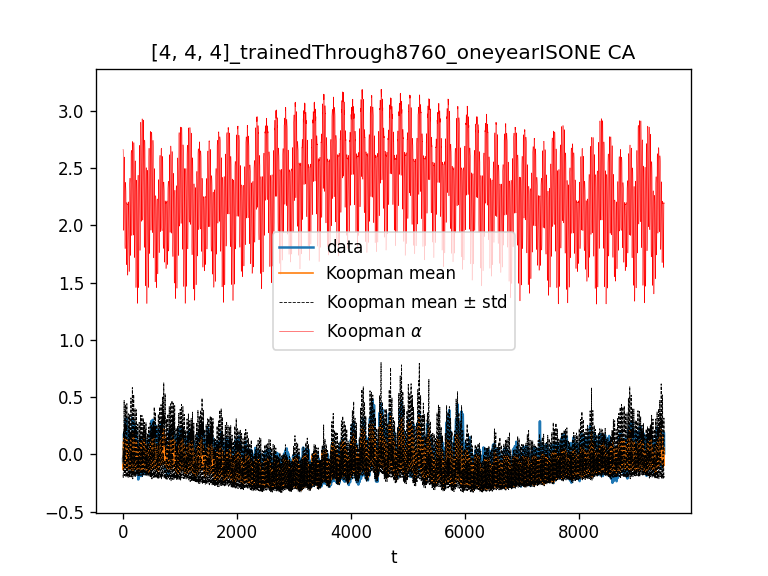

In [95]:
%matplotlib notebook

mean_hat = model.mean(params)
std_hat = model.std(params)
for dim in range(xt.shape[1]):
    plt.figure()
    # plt.scatter(np.arange(-slc), x[slc:], label="data")
    plt.plot(x[:predict_through, dim], label="data")
    plt.plot(mean_hat[:, dim], label="Koopman mean", linewidth=1)
    plt.plot(mean_hat[:, dim] + std_hat[:, dim], "--", color="black", label="Koopman mean $\pm$ std", linewidth=0.5)
    plt.plot(mean_hat[:, dim] - std_hat[:, dim], "--", color="black", linewidth=0.5)
    plt.plot(a_hat[:, dim], color="red", linewidth=0.3, label="Koopman $\\alpha$")
#     plt.plot(std_hat[:, dim], color="green", linewidth=0.7, label="Koopman std")

    # plt.plot(mu_vec[slc:], label="real mu")
    # plt.plot(mu_hat[slc:, 0], label="koopman mu")
    # plt.legend()
    # plt.show()
    #
    # plt.plot(sigma_vec[slc:], label="real sigma")
    #     plt.plot(3*sigma_hat[:, dim], label="koopman $3\sigma$", linewidth=0.7)
    plt.title(f"{num_freqs}_trainedThrough{train_through}_" + data_name)
    plt.xlabel("t")
    plt.legend()
    plt.show()

In [96]:
# plt.figure()
# plt.plot(np.arange(len(oldx), len(oldx) + len(x_original)), x_original, label="2021")
# plt.plot(oldx, label="demand 2005-15")
# plt.legend()
# plt.show()

In [97]:
print("actual overall mean:", 0, " predicted mean:", np.mean(mean_hat[:train_through]))

actual overall mean: 0  predicted mean: -0.0619289


In [98]:
"mean of a_hat", np.mean(a_hat), "std of a_hat", np.std(a_hat)

('mean of a_hat', 2.3238902, 'std of a_hat', 0.4065727)

In [99]:
def normal_pdf(mu, sigma, x):
    return np.exp(-(x - mu)**2 / (2 * sigma**2))/((2 * np.pi * sigma**2)**0.5)

In [100]:
z_scores = ((x[:train_through] - mean_hat[:train_through]) / std_hat[:train_through])
# z_scores = ((x[train_through:predict_through] - mean_hat[train_through:]) / std_hat[train_through:])[:8760, 0]
# z_scores /= np.std(z_scores)
z_hist, bin_edges = np.histogram(z_scores, bins=40, density=True)
z_axis = (bin_edges[1:] + bin_edges[:-1]) / 2

In [101]:
print(np.std(z_scores))
np.mean(z_scores)

0.8643478605062548


0.5279346986161789

<IPython.core.display.Javascript object>


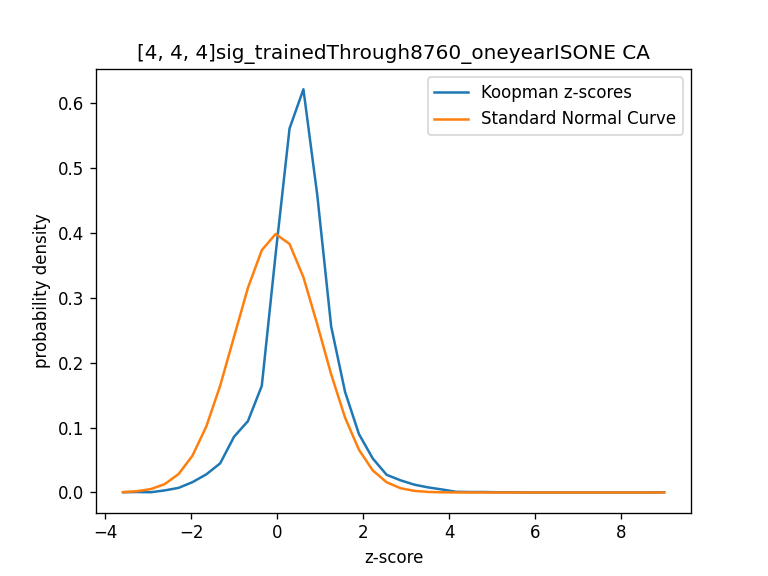

In [102]:
plt.figure()
plt.plot(z_axis, z_hist, label="Koopman z-scores")
plt.plot(z_axis, normal_pdf(0, 1, z_axis), label="Standard Normal Curve")
plt.title(f"{num_freqs}sig_trainedThrough{train_through}_" + data_name)
plt.xlabel("z-score")
plt.ylabel("probability density")
plt.legend()

In [81]:
mu_hat -= np.mean(mean_hat[:train_through])

# Pinball Loss

In [82]:
def skew_pinball_loss(data, mus, sigmas, alphas, quantiles=range(10, 100, 10)):
    loss = 0
    for i in range(len(data)):
        for q in quantiles:
            q = q / 100
            quant_pred = skewnorm.ppf(q, alphas[i], loc=mus[i], scale=sigmas[i])
            if quant_pred > data[i]:
                loss += (quant_pred - data[i]) * (1 - q)
            else:
                loss += (data[i] - quant_pred) * q
    return loss / (len(data) * len(quantiles))

In [83]:
def normal_pinball_loss(data, mus, sigmas, quantiles=range(10, 100, 10)):
    loss = 0
    for i in range(len(data)):
        for q in quantiles:
            q = q / 100
            quant_pred = norm.ppf(q, loc=mus[i], scale=sigmas[i])
            if quant_pred > data[i]:
                loss += (quant_pred - data[i]) * (1 - q)
            else:
                loss += (data[i] - quant_pred) * q
    return loss / (len(data) * len(quantiles))

<IPython.core.display.Javascript object>


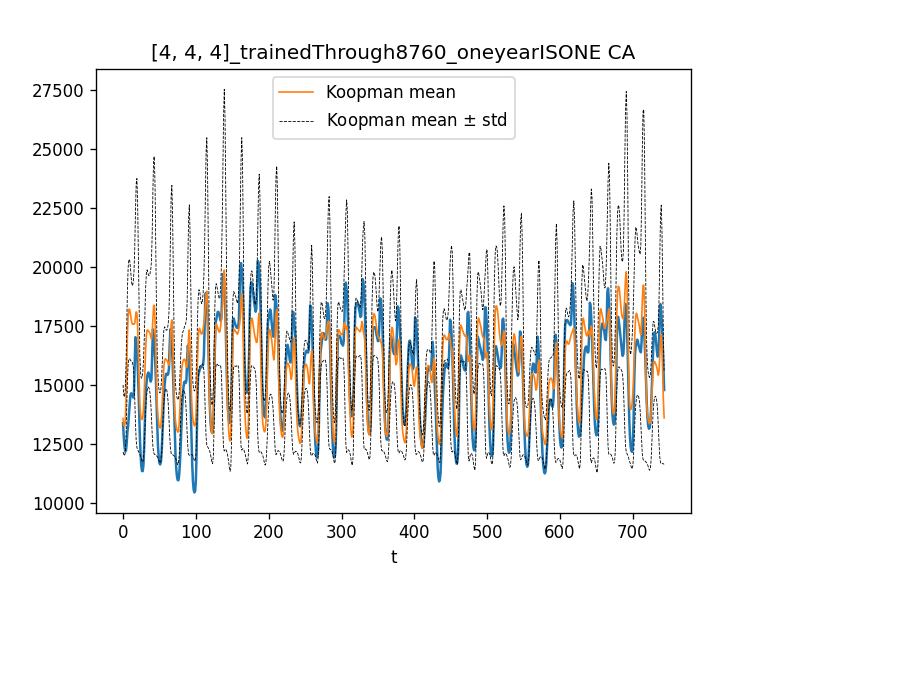

In [84]:
test_start = train_through + delay
# Skew Normal Distribution rescaling
sigh, ah = sigma_hat[test_start: predict_through], a_hat[test_start: predict_through]
delta = ah / (1 + ah ** 2) ** 0.5
muh = mu_hat[test_start: predict_through] * rnge + (rnge - 1) * delta * sigh * (2 / np.pi) ** 0.5
muh = muh + mean - (rnge - 1) * delta * sigh * (2 / np.pi) ** 0.5
sigh = sigh * rnge
mean_hat = model.mean([muh, sigh, ah])
std_hat = model.std([muh, sigh, ah])

# # Normal Distribution
# sigh = sigma_hat[test_start: predict_through] * rnge
# muh = mu_hat[test_start: predict_through] * rnge + mean
# mean_hat = model.mean([muh, sigh])
# std_hat = model.std([muh, sigh])

plt.figure()
plt.plot(x_original[train_start:][test_start: predict_through])
plt.plot(mean_hat[:, dim], label="Koopman mean", linewidth=1)
plt.plot(mean_hat[:, dim] + std_hat[:, dim], "--", color="black", label="Koopman mean $\pm$ std", linewidth=0.5)
plt.plot(mean_hat[:, dim] - std_hat[:, dim], "--", color="black", linewidth=0.5)
# plt.plot(ah[:, dim], color="red", linewidth=0.3, label="Koopman $\\alpha$")
# plt.plot(std_hat[:, dim], color="green", linewidth=0.7, label="Koopman std")
plt.title(f"{num_freqs}_trainedThrough{train_through}_" + data_name)
plt.xlabel("t")
plt.legend()
plt.show()

In [85]:
# loss = normal_pinball_loss(x_original[train_start:][test_start: predict_through], muh, sigh)
loss = skew_pinball_loss(x_original[train_start:][test_start: predict_through], muh, sigh, ah)
print(loss)

[441.91462544]


In [87]:
import vanilla_benchmark

vanilla_losses = vanilla_benchmark.get_lossesGEFCom(start=train_start, plot=False)
print(vanilla_losses)

ISONE CA
start: 2014-01-01 00:00:00
ME
start: 2014-01-01 00:00:00
RI
start: 2014-01-01 00:00:00
VT
start: 2014-01-01 00:00:00
CT
start: 2014-01-01 00:00:00
NH
start: 2014-01-01 00:00:00
SEMASS
start: 2014-01-01 00:00:00
WCMASS
start: 2014-01-01 00:00:00
NEMASSBOST
start: 2014-01-01 00:00:00
{'ISONE CA': 381.90378149175325, 'ME': 29.5225280460456, 'RI': 24.10316079531464, 'VT': 15.967894087158326, 'CT': 106.84865130851064, 'NH': 36.62805990777599, 'SEMASS': 48.63787072147622, 'WCMASS': 55.24190168505761, 'NEMASSBOST': 80.30352911316842}


In [88]:
1 - loss/vanilla_losses[zone_name]

# with 52 day gap between training and testing
# 1 - loss / 84.2  # WCMASS +25%
# 1 - loss / 122.8  # NEMASSBOST 39.4%
# 1 - loss / 596  # ISONE 19.4%
# VT: +9.2%
# (old--Monday=0) {'ISONE CA': 523.7428637110866, 'ME': 58.71157246544602, 'RI': 36.73051071209801, 'VT': 22.977155005752657, 'CT': 141.30040329213762, 'NH': 63.25224646477936, 'SEMASS': 65.42717786334023, 'WCMASS': 70.82418918073226, 'NEMASSBOST': 110.09485925971588}


array([-0.15713603])

In [68]:
import os

folder = ".\\forecasts\GEFComFirstQualTest"
a_hat = np.load(os.path.join(folder, "WCMASStrained-17520-8760_[6, 6, 6]alpha.npy"))
mu_hat = np.load(os.path.join(folder, "WCMASStrained-17520-8760_[6, 6, 6]mu.npy"))
sigma_hat = np.load(os.path.join(folder, "WCMASStrained-17520-8760_[6, 6, 6]sigma.npy"))

In [141]:
with open("GEFCom2017//GEFCom2017-Qual//GEFCom2017Qual2005-2015.json") as f:
    all_data1 = json.loads(f.read())
    
with open("GEFCom2017//GEFCom2017-Qual//GEFCom2017Qual2016.json") as f:
    all_data2 = json.loads(f.read())
    
with open("GEFCom2017//GEFCom2017-Qual//GEFCom2017Qual2017.json") as f:
    all_data3 = json.loads(f.read())

In [142]:
zone_name = 'WCMASS'

In [143]:
all_data1[zone_name].keys()

dict_keys(['Date', 'Hour', 'DA_DEMD', 'DEMAND', 'DA_LMP', 'DA_EC', 'DA_CC', 'DA_MLC', 'RT_LMP', 'RT_EC', 'RT_CC', 'RT_MLC', 'DryBulb', 'DewPnt'])

In [144]:
all_data2[zone_name].keys()

dict_keys(['Date', 'Hr_End', 'DA_Demand', 'RT_Demand', 'DA_LMP', 'DA_EC', 'DA_CC', 'DA_MLC', 'RT_LMP', 'RT_EC', 'RT_CC', 'RT_MLC', 'Dry_Bulb', 'Dew_Point'])

In [145]:
all_data3[zone_name].keys()

dict_keys(['Date', 'Hr_End', 'DA_Demand', 'RT_Demand', 'DA_LMP', 'DA_EC', 'DA_CC', 'DA_MLC', 'RT_LMP', 'RT_EC', 'RT_CC', 'RT_MLC', 'Dry_Bulb', 'Dew_Point'])

In [146]:
rename_isone = {'Date': 'Date',
        'Hr_End': 'Hour',
        'DA_Demand': 'DA_DEMD',
        'RT_Demand': 'DEMAND',
        'DA_LMP': 'DA_LMP',
        'DA_EC': 'DA_EC',
        'DA_CC': 'DA_CC',
        'DA_MLC': 'DA_MLC',
        'RT_LMP': 'RT_LMP',
        'RT_EC': 'RT_EC',
        'RT_CC': 'RT_CC',
        'RT_MLC': 'RT_MLC',
        'Dry_Bulb': 'DryBulb',
        'Dew_Point': 'DewPnt',
        'System_Load': 'SYSLoad',
        'Reg_Capacity_Price': 'RegCP'
       }
rename = {'Date': 'Date',
        'Hr_End': 'Hour',
        'DA_Demand': 'DA_DEMD',
        'RT_Demand': 'DEMAND',
        'DA_LMP': 'DA_LMP',
        'DA_EC': 'DA_EC',
        'DA_CC': 'DA_CC',
        'DA_MLC': 'DA_MLC',
        'RT_LMP': 'RT_LMP',
        'RT_EC': 'RT_EC',
        'RT_CC': 'RT_CC',
        'RT_MLC': 'RT_MLC',
        'Dry_Bulb': 'DryBulb',
        'Dew_Point': 'DewPnt',
       }

In [147]:
all_data = all_data1.copy()

In [148]:
for zone in all_data.keys():
    if zone == "ISONE CA":
        for quantity in rename_isone.keys():
            name = rename_isone[quantity]
            all_data[zone][name].extend(all_data2[zone][quantity])
            all_data[zone][name].extend(all_data3[zone][quantity])
    else:
        for quantity in rename.keys():
            name = rename[quantity]
            all_data[zone][name].extend(all_data2[zone][quantity])
            
            all_data[zone][name].extend(all_data3[zone][quantity])
            

In [149]:
x = np.array(all_data[zone_name]["DEMAND"])

In [150]:
x1 = (all_data1[zone_name]["DEMAND"])

In [151]:
len(x2), len(x3), len(x)

(8784, 8760, 113952)

In [152]:
import pandas as pd

In [153]:
dates = np.array(list(map(pd.Timestamp, all_data["ISONE CA"]["Date"])))
hours = np.array(list(pd.Timedelta(hours=h-1) for h in all_data["ISONE CA"]["Hour"]))
dates += hours
dates = list(map(str, dates))

In [154]:
for zone in all_data.keys():
    all_data[zone]["Date"] = dates

In [155]:
all_data[zone_name].keys()

dict_keys(['Date', 'Hour', 'DA_DEMD', 'DEMAND', 'DA_LMP', 'DA_EC', 'DA_CC', 'DA_MLC', 'RT_LMP', 'RT_EC', 'RT_CC', 'RT_MLC', 'DryBulb', 'DewPnt'])

In [156]:
len(all_data[zone]["Date"]) / 8760

13.008219178082191

In [157]:
json_data = json.dumps(all_data)
with open("GEFCom2017//GEFCom2017-Qual//GEFCom2017QualAll.json", "w") as f:
    f.write(json_data)